## Imports and settings

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from scipy.stats import norm

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

2.9.0


# OmniFold Gaussian Toy Example

There are five datasets:

**Natural**
* Truth -> the target
* Data -> what we actually observe from the detector

**Synthetic**
* Generation -> particle-level Monte Carlo
* Simulation -> result of passing the particle-level Monte Carlo through the detector emulation; we have pairs of events (generated, simulated)
* Background -> simulations (possibly partially or wholely derived from data) of non-target processes

The unfolding has 4 parts:

1. Remove background
2. Account for events that pass reco but not true
3. Correct for detector distortions (deconvolution)
4. Account for events that pass true but not reco

In what follows, we do step (1) and then (2) - (4) are combined.

## Setup the Datasets

In [4]:
mu0 = 0
sigma0 = 1

eff = 0.1 #fraction of true but not reco
fake = 0.1 #fraction of reco but not true

back = 0.1 #fraction of a background process that we would like to subtract

In [5]:
def reweighting(xx,mu0,mu1,sigma0,sigma1):
    starting = norm.pdf((xx-mu0)/sigma0)
    target = norm.pdf((xx-mu1)/sigma1)
    return target/starting

(array([6.63983340e-06, 6.73118067e-05, 5.13078551e-04, 2.62051463e-03,
        1.30687685e-02, 4.75395804e-02, 1.13172667e-01, 2.31211705e-01,
        3.52409257e-01, 3.96617363e-01, 3.39762178e-01, 2.19962421e-01,
        1.20231338e-01, 4.71366041e-02, 1.22657894e-02, 2.82169899e-03,
        5.14981180e-04, 7.05165726e-05, 7.58724549e-06]),
 array([-5.        , -4.47368421, -3.94736842, -3.42105263, -2.89473684,
        -2.36842105, -1.84210526, -1.31578947, -0.78947368, -0.26315789,
         0.26315789,  0.78947368,  1.31578947,  1.84210526,  2.36842105,
         2.89473684,  3.42105263,  3.94736842,  4.47368421,  5.        ]),
 [<matplotlib.patches.Polygon at 0x7f7669369cd0>])

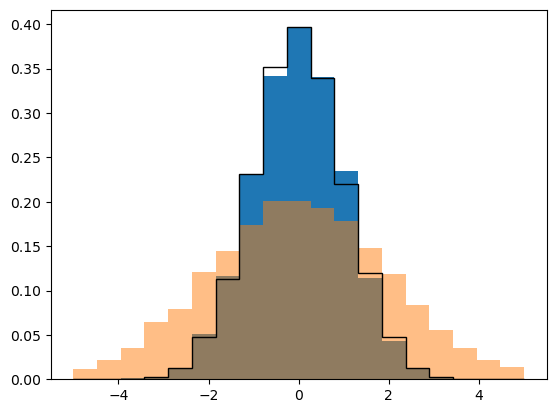

In [6]:
xx = np.linspace(-5,5,20)
plt.hist(np.random.normal(0,1,10000),bins=xx,density=True)
plt.hist(np.random.normal(0,2,10000),bins=xx,alpha=0.5,density=True)
vals = np.random.normal(0,2,10000)
plt.hist(vals,bins=xx,weights=reweighting(vals,0,0,2,1),density=True,histtype="step",color="black")

In [7]:
N = 10**5
# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (0.2, 0.8)  # this is the data (the target)
background_param = (0, 1.2)  # background
epsilon = sigma0 / 2.  # Smearing width

dummyval = -10 #a value for examples that don't pass one of the measured/ideal selections

#Synthetic
x_gen = np.random.normal(theta0_param[0], theta0_param[1],N)
x_sim = np.array([(x + np.random.normal(0, epsilon)) for x in x_gen])
pass_reco = np.random.binomial(1,1.-eff,len(x_gen))
pass_truth = np.random.binomial(1,1.-fake,len(x_gen))
x_gen[pass_truth==0] = dummyval
x_sim[pass_reco==0] = dummyval
w_synth = np.ones(len(x_gen))
w_synth = w_synth*len(w_synth)/np.sum(w_synth)

x_background = np.random.normal(background_param[0],background_param[1], int(N*back))
w_back = reweighting(x_background,background_param[0],background_param[0],background_param[1],background_param[1]*0.8)
w_back = w_back*len(w_back)/np.sum(w_back) #pick weights so that they don't change sum (N.B. this changes statistical power, but I don't care for this example)
x_sim_withback = np.concatenate([x_sim,x_background]) #sim with background added
x_gen_withback= np.concatenate([x_gen,-np.ones(int(N*back))*dummyval]) #gen with background added; since background has no corresponding truth in the fiducial volume, set to dummy value
w_synth_withback = np.concatenate([w_synth,w_back])

x_synth = np.stack([x_gen, x_sim], axis=1)
y_synth = np.zeros(len(x_synth))

#Natural
x_truth = np.random.normal(theta_unknown_param[0],theta_unknown_param[1], N) # Nature, particle-level analog
x_data = np.array([(x + np.random.normal(0, epsilon)) for x in x_truth]) # Measured Data analog
pass_reco = np.random.binomial(1,1.-eff,len(x_truth))
pass_truth = np.random.binomial(1,1.-fake,len(x_truth))
x_truth[pass_truth==0] = dummyval
x_data[pass_reco==0] = dummyval #emulates cuts done in an analysis

x_background_real = np.random.normal(background_param[0],background_param[1]*0.8, int(N*back))
x_data_withback = np.concatenate([x_data,x_background_real]) #Data+Background
x_truth_withback = np.concatenate([x_truth,-np.ones(int(N*back))*dummyval]) #Nature+background

x_natural = np.stack([x_truth, x_data], axis=1)
y_natural = np.ones(len(x_natural))

(0.0, 3018.6)

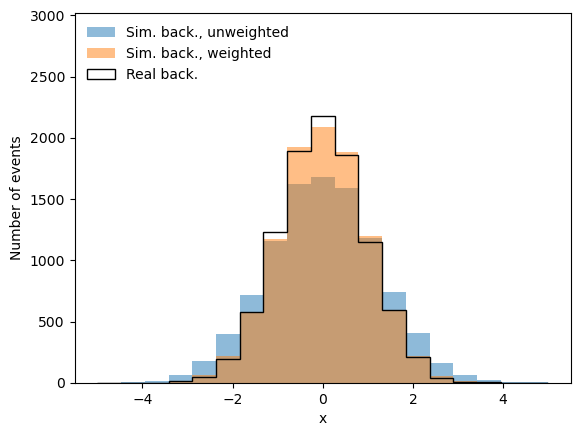

In [8]:
#Check that I did the background weighting properly.
binning = np.linspace(-5,5,20)
ns,_,_=plt.hist(x_background,bins=binning,alpha=0.5,label="Sim. back., unweighted")
_,_,_=plt.hist(x_background,bins=binning,weights=w_back,alpha=0.5,label="Sim. back., weighted")
_,_,_=plt.hist(x_background_real,bins=binning,histtype="step",color="black",label="Real back.")
plt.legend(frameon=False,loc="upper left")
plt.ylabel("Number of events")
plt.xlabel("x")
plt.ylim([0,1.8*np.max(ns)])

(0.0, 33943.30261419679)

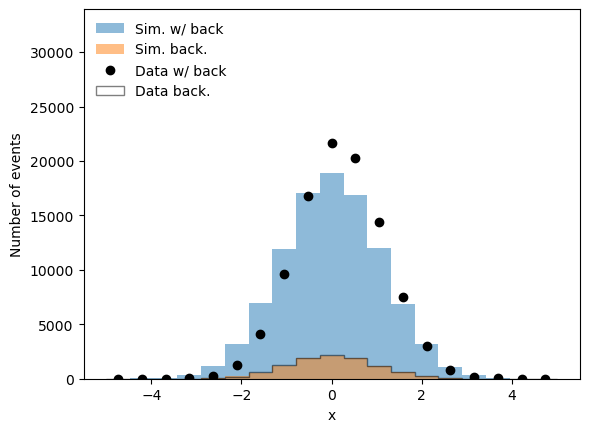

In [9]:
#Now the full data/sim. including background
binning = np.linspace(-5,5,20)
ns,_,_=plt.hist(x_sim_withback[x_sim_withback!=dummyval],weights=w_synth_withback[x_sim_withback!=dummyval],bins=binning,alpha=0.5,label="Sim. w/ back")
_,_,_=plt.hist(x_background,bins=binning,weights=w_back,alpha=0.5,label="Sim. back.")
dplot=np.histogram(x_data_withback[x_data_withback!=dummyval],bins=binning)
plt.plot(0.5*(dplot[1][1:]+dplot[1][:-1]),dplot[0],label="Data w/ back",ls="",marker='o',color="black")
_,_,_=plt.hist(x_background_real,bins=binning,alpha=0.5,label="Data back.",histtype="step",color="black")
plt.legend(frameon=False,loc="upper left")
plt.ylabel("Number of events")
plt.xlabel("x")
plt.ylim([0,1.8*np.max(ns)])

## Let's first subtract the background
(see https://arxiv.org/abs/2007.11586 and https://arxiv.org/abs/2105.04448 for details)

Loss function for this step is

$L[f] = - \sum_\text{data} \log(f(x_i)) + \sum_\text{back. MC} w_i\log(f(x_i)) - \sum_\text{data} \log(1-f(x_i))$

The binary cross entropy loss is

$L[f] = -\sum y_i\log(f(x_i)) -\sum (1-y_i)\log(f(x_i))$

Thus, in order to achieve the desired loss, we add the data in twice, once with $y = 1$ and once with $y = 0$ and then we add in the background simulation with a negative weight and $y=1$.

In [10]:
x_data_and_MCback = np.concatenate([x_background[x_background!=dummyval],
                                    x_data_withback[x_data_withback!=dummyval],
                                    x_data_withback[x_data_withback!=dummyval]])
    
y_data_and_MCback = np.concatenate([np.ones(len(x_background[x_background!=dummyval])),
                                    np.ones(len(x_data_withback[x_data_withback!=dummyval])),
                                    np.zeros(len(x_data_withback[x_data_withback!=dummyval]))])
    
W_data_and_MCback = np.concatenate([-1.*w_back[x_background!=dummyval],
                                    np.ones(len(x_data_withback[x_data_withback!=dummyval])),
                                    np.ones(len(x_data_withback[x_data_withback!=dummyval]))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
    x_data_and_MCback, y_data_and_MCback, W_data_and_MCback)

#I did not optimize this network at all; it should probably be quite good for simple problems.  Could also swap out with a BDT for low-dimensional/tabular data.
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)
    
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'],
              weighted_metrics=[]) #to silence an annoying warning ... could compute the weighted accuracy
model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=200,
          batch_size=10000,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=0)

2024-07-05 00:29:30.595567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-05 00:29:31.237639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1024 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0
2024-07-05 00:29:49.899142: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Restoring model weights from the end of the best epoch: 4.
Epoch 14: early stopping


### Check that the subtraction worked!

In [11]:
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f) #for binary cross entropy - see refs. above and https://arxiv.org/abs/2101.07263 for more info.
    return np.squeeze(np.nan_to_num(weights)) 

In [12]:
w_data = reweight(x_data_withback)

11/11 [==============================] - 0s 866us/step


(0.0, 33943.30261419679)

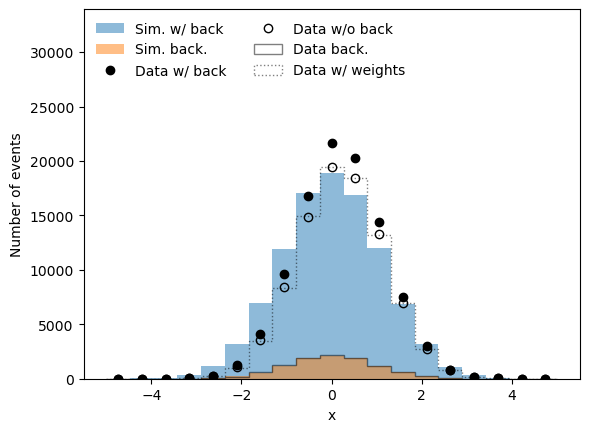

In [13]:
#Now the full data/sim. including background
binning = np.linspace(-5,5,20)
ns,_,_=plt.hist(x_sim_withback[x_sim_withback!=dummyval],weights=w_synth_withback[x_sim_withback!=dummyval],bins=binning,alpha=0.5,label="Sim. w/ back")
_,_,_=plt.hist(x_background,bins=binning,weights=w_back,alpha=0.5,label="Sim. back.")
dplot=np.histogram(x_data_withback[x_data_withback!=dummyval],bins=binning)
plt.plot(0.5*(dplot[1][1:]+dplot[1][:-1]),dplot[0],label="Data w/ back",ls="",marker='o',color="black")

dplot2=np.histogram(x_data[x_data!=dummyval],bins=binning)
plt.plot(0.5*(dplot2[1][1:]+dplot2[1][:-1]),dplot2[0],label="Data w/o back",ls="",marker='o',color="black",markerfacecolor="none")

_,_,_=plt.hist(x_background_real,bins=binning,alpha=0.5,label="Data back.",histtype="step",color="black")
_,_,_=plt.hist(x_data_withback[x_data_withback!=dummyval],weights=w_data[x_data_withback!=dummyval],bins=binning,alpha=0.5,label="Data w/ weights",histtype="step",color="black",ls=":")
plt.legend(frameon=False,loc="upper left",ncols=2)
plt.ylabel("Number of events")
plt.xlabel("x")
plt.ylim([0,1.8*np.max(ns)])

## Now we can unfold the background-subtracted data.

In [14]:
iterations = 4

weights = np.empty(shape=(iterations, 2, len(x_gen)))
# shape = (iteration, step, event)

In [16]:
# initial iterative weights are ones
weights_pull = np.ones(len(x_sim))
weights_push = np.ones(len(x_sim))

In [17]:
xvals_1 = np.concatenate((x_sim, x_data_withback))
yvals_1 = np.concatenate((np.zeros(len(x_sim)), np.ones(len(x_data_withback))))

xvals_2 = np.concatenate((x_gen, x_gen))
yvals_2 = np.concatenate((np.zeros(len(x_gen)), np.ones(len(x_gen))))

Step 1 loss function is (weight MC to match data)

$L[f] = -\sum_\text{Data} w_i \log(f(x_i))-\sum_\text{MC}\omega_iw_i\log(1-f(x_i))$

while for Step 2, the loss function is (reweight nominal MC to the weighted MC)

$L[f] = -\sum_\text{MC} \nu_iw_i \log(f(z_i))-\sum_\text{MC}w_i\log(1-f(z_i))$

where $\omega_i$ are the push weights from the previous step and $\nu_i$ are the pull weights from the previous step.  $x$ is detector level and $z$ is particle level.

In [18]:
iterations = 4

In [19]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push*w_synth, w_data))

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1) 

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'],
                  weighted_metrics=[])
    model.fit(X_train_1[X_train_1!=dummyval],
              Y_train_1[X_train_1!=dummyval],
              sample_weight=w_train_1[X_train_1!=dummyval],
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1[X_test_1!=dummyval], Y_test_1[X_test_1!=dummyval], w_test_1[X_test_1!=dummyval]),
              callbacks=[earlystopping],
              verbose=0)

    weights_pull = weights_push * reweight(x_sim) 
    
    #One option is to take the prior:
    weights_pull[x_sim==dummyval] = 1. 
    
    #Another (more complicated) option is to assign the average weight: <w|x_true>.  To do this, we need to estimate this quantity.
    #xvals_1b = np.concatenate([x_gen[x_sim!=dummyval],x_gen[x_sim!=dummyval]])
    #yvals_1b = np.concatenate([np.ones(len(x_gen[x_sim!=dummyval])),np.zeros(len(x_gen[x_sim!=dummyval]))])
    #weights_1b = np.concatenate([weights_pull[x_sim!=dummyval],np.ones(len(x_gen[x_sim!=dummyval]))])
    
    #X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
    #    xvals_1b, yvals_1b, weights_1b)    
    
    #model.compile(loss='binary_crossentropy',
    #              optimizer='Adam',
    #              metrics=['accuracy'])
    #model.fit(X_train_1b,
    #          Y_train_1b,
    #          sample_weight=w_train_1b,
    #          epochs=200,
    #          batch_size=10000,
    #          validation_data=(X_test_1b, Y_test_1b, w_test_1b),
    #          callbacks=[earlystopping],
    #          verbose=1)
    
    #average_vals = reweight(x_gen[x_sim==dummyval])
    #weights_pull[x_sim==dummyval] = average_vals
    ###
    
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((w_synth, weights_pull*w_synth))

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'],
                  weighted_metrics=[])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=2000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=0)

    weights_push = reweight(x_gen)
    ###
    #Need to do something with events that don't pass truth    
    
    #One option is to take the prior:
    weights_push[x_gen==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_reco>.  To do this, we need to estimate this quantity.
    #xvals_1b = np.concatenate([x_sim[x_gen!=dummyval],x_sim[x_gen!=dummyval]])
    #yvals_1b = np.concatenate([np.ones(len(x_sim[x_gen!=dummyval])),np.zeros(len(x_sim[x_gen!=dummyval]))])
    #weights_1b = np.concatenate([weights_push[x_gen!=dummyval],np.ones(len(x_sim[x_gen!=dummyval]))])
    
    #X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
    #    xvals_1b, yvals_1b, weights_1b)    
    
    #model.compile(loss='binary_crossentropy',
    #              optimizer='Adam',
    #              metrics=['accuracy'])
    #model.fit(X_train_1b,
    #          Y_train_1b,
    #          sample_weight=w_train_1b,
    #          epochs=200,
    #          batch_size=10000,
    #          validation_data=(X_test_1b, Y_test_1b, w_test_1b),
    #          callbacks=[earlystopping],
    #          verbose=1)
    
    #average_vals = reweight(x_sim[x_gen==dummyval])
    #weights_push[x_gen==dummyval] = average_vals
    ###    
    
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Restoring model weights from the end of the best epoch: 36.
Epoch 46: early stopping
10/10 [==============================] - 0s 843us/step

STEP 2

Restoring model weights from the end of the best epoch: 42.
Epoch 52: early stopping
10/10 [==============================] - 0s 892us/step

ITERATION: 2

STEP 1

Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping
10/10 [==============================] - 0s 842us/step

STEP 2

Restoring model weights from the end of the best epoch: 11.
Epoch 21: early stopping
10/10 [==============================] - 0s 843us/step

ITERATION: 3

STEP 1

Restoring model weights from the end of the best epoch: 32.
Epoch 42: early stopping
10/10 [==============================] - 0s 949us/step

STEP 2

Restoring model weights from the end of the best epoch: 9.
Epoch 19: early stopping
10/10 [==============================] - 0s 926us/step

ITERATION: 4

STEP 1

Restoring model weights from the end of th

(0.0, 33816.6)

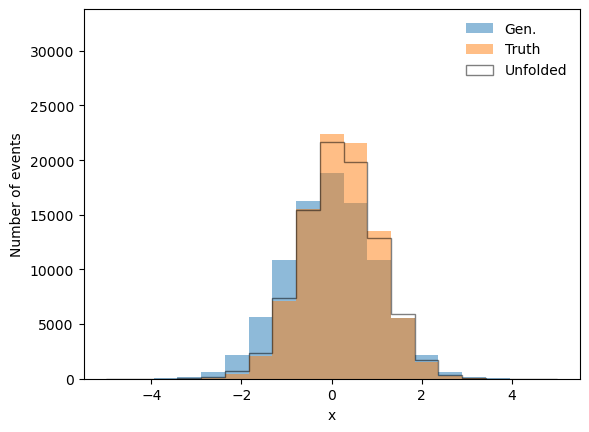

In [20]:
#Now the full data/sim. including background
binning = np.linspace(-5,5,20)
ns,_,_=plt.hist(x_gen[x_gen!=dummyval],weights=w_synth[x_gen!=dummyval],bins=binning,alpha=0.5,label="Gen.")
_,_,_=plt.hist(x_truth[x_truth!=dummyval],bins=binning,alpha=0.5,label="Truth")
_,_,_=plt.hist(x_gen[x_gen!=dummyval],weights=w_synth[x_gen!=dummyval]*weights[3, 1:2, :][0][x_gen!=dummyval],bins=binning,alpha=0.5,label="Unfolded",histtype="step",color="black")

plt.legend(frameon=False)
plt.ylabel("Number of events")
plt.xlabel("x")
plt.ylim([0,1.8*np.max(ns)])